# Modeling

## Config


In [75]:
import pandas as pd

In [76]:
# Local imports
import sys
sys.path.append('../code')
 
from utils import null_detection

from variable_reduction import iv, chi2_test
from variable_reduction import fit_deciles, transform_deciles
from aws import s3_bucket

In [77]:
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Read credentials
import configparser

credentials_file="..\config\credentials.ini"
config = configparser.ConfigParser()
config.read(credentials_file)

aws_access_key_id = config.get('AWS', 'aws_access_key_id')
aws_secret_access_key = config.get('AWS', 'aws_secret_access_key')

### S3 Connection

In [79]:
# S3 connection
bucket = s3_bucket(
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
    bucket_name='moneylion-project'
)

## Load Data

In [80]:
#Read Loan Data
#df = pd.read_csv(r'..\data\output\full_data_df.csv')
df = bucket.read_csv(file='output/full_data_df.csv')

df.shape

(17506, 72)

### Null Check

In [81]:
null_detection(df)

Null count per column:
Series([], dtype: int64)

Percentage of nulls per column:
Series([], dtype: float64)


### Irrelevant Vars

In [82]:
#Drop Columns with 1 unique value
columns_to_drop = df.columns[df.nunique() == 1].to_list()
df.drop(columns=columns_to_drop, inplace=True)

print("Dropped Columns with 1 unique value:")
columns_to_drop

Dropped Columns with 1 unique value:


['originated', 'nPaidOff', 'approved', 'isFunded', 'hasCF', 'isClosedLoan']

## Macro Variables

In [83]:
# Unit of measure
um = 'loanId'

#Target
target = "Risk"
#target = "HighRisk"

In [84]:
# Performance Variables
post_vars = [
"paymentAmountPaid",        	
"principalPaid",	
"feesPaid", 
"GrossMargin",
"NetMargin",

#"NetMargin_pct",
]

In [85]:
# Origination Variables
t0_vars = [
    'payFrequency',
    'apr',
    'applicationDate',
    'originatedDate',
    'loanStatus',
    'loanAmount',
    'originallyScheduledPaymentAmount',
    'state',
    'leadType',
    'leadCost',
]

In [86]:
#Prior Variables
prior_vars = [
    'thirtydaysago',
    'twentyfourhoursago',
    'oneminuteago',
    'onehourago',
    'ninetydaysago',
    'sevendaysago',
    'tenminutesago',
    'fifteendaysago',
    'threesixtyfivedaysago',
    'inquiryonfilecurrentaddressconflict',
    'totalnumberoffraudindicators',
    'telephonenumberinconsistentwithaddress',
    'inquiryageyoungerthanssnissuedate',
    'onfileaddresscautious',
    'inquiryaddressnonresidential',
    'onfileaddresshighrisk',
    'ssnreportedmorefrequentlyforanother',
    'currentaddressreportedbytradeopenlt90days',
    'inputssnissuedatecannotbeverified',
    'inquiryaddresscautious',
    'morethan3inquiriesinthelast30days',
    'onfileaddressnonresidential',
    'creditestablishedpriortossnissuedate',
    'driverlicenseformatinvalid',
    'inquiryaddresshighrisk',
    'inquirycurrentaddressnotonfile',
    'highprobabilityssnbelongstoanother',
    'maxnumberofssnswithanybankaccount',
    'currentaddressreportedbynewtradeonly',
    'creditestablishedbeforeage18',
    'telephonenumberinconsistentwithstate',
    'driverlicenseinconsistentwithonfile',
    'workphonepreviouslylistedascellphone',
    'workphonepreviouslylistedashomephone',
    'ssnnamematch',
    'nameaddressmatch',
    'phonematchtype',
    'phonematchresult',
    'overallmatchresult',
    'ssndobmatch',
    'overallmatchreasoncode',
    'clearfraudscore',

#    'phonematchtypedescription',
#    'underwritingid'
]

### Independent Variables

In [87]:
# Get Usefull variables from Origination for the ML Model
lst_t0_vars_to_predict =[
    "payFrequency",
    "apr",
    "loanAmount",
    "state",
    "leadType",
]

In [88]:
# Join Prior + t0_vars_to_predict 
independent_variables = prior_vars + lst_t0_vars_to_predict
print("Variables for the ML Model:", len(independent_variables))

Variables for the ML Model: 47


### NUMERIC Variables

In [89]:
# Booleans into Int
boolean_columns = df[independent_variables].select_dtypes(include='bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)

In [90]:
#Get Numeric Variables
NUM_VARS = df[independent_variables].select_dtypes(exclude=['object','bool']).columns.tolist()
print("NUM VARS:", len(NUM_VARS))

NUM VARS: 38


### CATEGORICAL Variables

In [91]:
#Get Categorical Variables
CAT_VARS = df[independent_variables].select_dtypes(include='object').columns.tolist()
print("CAT VARS:", len(CAT_VARS))
CAT_VARS

CAT VARS: 9


['ssnnamematch',
 'nameaddressmatch',
 'phonematchtype',
 'phonematchresult',
 'overallmatchresult',
 'ssndobmatch',
 'payFrequency',
 'state',
 'leadType']

## Train Test Split

In [92]:
print(f"Avg Target: {df[target].mean():.2%}")

Avg Target: 52.71%


In [93]:
X = df.drop(columns=["Risk","HighRisk"])
y = df[[target]]

In [94]:
# Stratified Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (13129, 64)
X_test: (4377, 64)


In [95]:
#Train Test DF
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

## Feature Reduction

### KEEP Information Value > 2%

In [96]:
# Run IV table
iv_table, drop_var_iv = iv(
    df = pd.concat([X_train,y_train],axis=1),
    features_list = NUM_VARS,
    target = target, 
    threshold = .02
)

d:\Users\luigi\Documents\GitLab\underwriting-risk-model\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
#INFORMATION VALUE
iv_table[iv_table["iv"]>.02]

variable        iv
0                       clearfraudscore  0.142766
1                                   apr  0.124022
2                            loanAmount  0.047514
3                 threesixtyfivedaysago  0.040552
4                         ninetydaysago  0.034010
5  workphonepreviouslylistedascellphone  0.020378

In [98]:
#Dropped Variables
drop_var_iv

['overallmatchreasoncode',
 'thirtydaysago',
 'inquirycurrentaddressnotonfile',
 'workphonepreviouslylistedashomephone',
 'inquiryonfilecurrentaddressconflict',
 'fifteendaysago',
 'totalnumberoffraudindicators',
 'onehourago',
 'driverlicenseformatinvalid',
 'sevendaysago',
 'twentyfourhoursago',
 'tenminutesago',
 'oneminuteago',
 'driverlicenseinconsistentwithonfile',
 'morethan3inquiriesinthelast30days',
 'maxnumberofssnswithanybankaccount',
 'onfileaddressnonresidential',
 'currentaddressreportedbytradeopenlt90days',
 'highprobabilityssnbelongstoanother',
 'inquiryaddressnonresidential',
 'currentaddressreportedbynewtradeonly',
 'ssnreportedmorefrequentlyforanother',
 'telephonenumberinconsistentwithstate',
 'inquiryaddresscautious',
 'inquiryaddresshighrisk',
 'creditestablishedbeforeage18',
 'inputssnissuedatecannotbeverified',
 'creditestablishedpriortossnissuedate',
 'inquiryageyoungerthanssnissuedate',
 'onfileaddresshighrisk',
 'telephonenumberinconsistentwithaddress',
 'onf

### KEEP Chi2 pval < 5

In [99]:
# Run Chi2 table
chi2_table, drop_var_chi2 = chi2_test(
    df = df,
    features_list = CAT_VARS, 
    target = target, 
    pvalue=.05
    )

In [100]:
# Chi2
chi2_table[chi2_table["pval"]<.05]

variable     pval
0    nameaddressmatch  0.00000
1  overallmatchresult  0.00000
2        payFrequency  0.00000
3               state  0.00000
4            leadType  0.00000
5      phonematchtype  0.00776
6    phonematchresult  0.01744

In [101]:
#Dropped Variables
drop_var_chi2

['ssnnamematch', 'ssndobmatch']

### Volume Report

In [102]:
# Volume Pipeline
VarRedPipeline = {}
VarRedPipeline["Independen Variables"] = {"N": len(independent_variables)}
VarRedPipeline["IV>2%"] = {"N": len(independent_variables) - len(drop_var_iv), "Dropped": len(drop_var_iv)}
VarRedPipeline["Chi2_pval<=5%"] = {"N": len(independent_variables) - len(drop_var_iv) - len(drop_var_chi2), "Dropped": len(drop_var_chi2)}

VarRedPipeline

{'Independen Variables': {'N': 47},
 'IV>2%': {'N': 15, 'Dropped': 32},
 'Chi2_pval<=5%': {'N': 13, 'Dropped': 2}}

- After a fisrt iteration variable "phonematchresult" was not significant enough at Variable Importance

In [103]:
# Volume Pipeline
VarRedPipeline = {}
VarRedPipeline["Independen Variables"] = {"N": len(independent_variables)}
VarRedPipeline["IV>2%"] = {"N": len(independent_variables) - len(drop_var_iv), "Dropped": len(drop_var_iv)}
VarRedPipeline["Chi2_pval<=5%"] = {"N": len(independent_variables) - len(drop_var_iv) - len(drop_var_chi2), "Dropped": len(drop_var_chi2)}

VarRedPipeline

{'Independen Variables': {'N': 47},
 'IV>2%': {'N': 15, 'Dropped': 32},
 'Chi2_pval<=5%': {'N': 13, 'Dropped': 2}}

## Modeling

- LightGBM

In [104]:
import lightgbm

In [105]:
# Final Model Variables
FINAL_NUM_VARS = [col for col in NUM_VARS if col not in drop_var_iv]
FINAL_CAT_VARS = [col for col in CAT_VARS if col not in drop_var_chi2]

print("FINAL_NUM_VARS :",len(FINAL_NUM_VARS))
print("FINAL_CAT_VARS :",len(FINAL_CAT_VARS))

FINAL_VARS = FINAL_NUM_VARS + FINAL_CAT_VARS


FINAL_NUM_VARS : 6
FINAL_CAT_VARS : 7


In [106]:
# Tranform into Category format. This is necessary for LightGBM model
for feature in FINAL_CAT_VARS:
    df_train[feature] = pd.Series(df_train[feature], dtype="category")
    df_test[feature] = pd.Series(df_test[feature], dtype="category")

### Grid Search CV

In [107]:
from sklearn.model_selection import GridSearchCV

- Set Grid Search Params

In [108]:
# Grid Search Params
param_grid = {
    'n_estimators': [50,100,150],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.025, 0.05, 0.1],
    'colsample_bytree': [0.8, 1],
    'subsample': [0.8, 1],
    'reg_alpha': [0.0, 0.1],
}

- Run Grid Search

In [109]:
model = lightgbm.LGBMClassifier(random_state=127)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    scoring = "precision"
    )

grid_search.fit(df_train[FINAL_VARS], df_train[target])

[LightGBM] [Info] Number of positive: 6920, number of negative: 6209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 13129, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527077 -> initscore=0.108416
[LightGBM] [Info] Start training from score 0.108416


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=127), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.025, 0.05, 0.1],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [20, 30, 40], 'reg_alpha': [0.0, 0.1],
                         'subsample': [0.8, 1]},
             scoring='precision')

### Best Model

In [110]:
print("param",grid_search.best_params_)
print("score",grid_search.best_score_)

param {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 30, 'reg_alpha': 0.1, 'subsample': 0.8}
score 0.6618854159764529


### Fit Model

In [111]:
model.set_params(**grid_search.best_params_)
model.fit(df_train[FINAL_VARS], df_train[target])

[LightGBM] [Info] Number of positive: 6920, number of negative: 6209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 13129, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527077 -> initscore=0.108416
[LightGBM] [Info] Start training from score 0.108416


LGBMClassifier(colsample_bytree=0.8, n_estimators=50, num_leaves=30,
               random_state=127, reg_alpha=0.1, subsample=0.8)

### Predict Score

In [112]:
# Get Probability Score
score_train = model.predict_proba(df_train[FINAL_VARS])[:,1]
df_train_w_score = df_train.copy()
df_train_w_score["score"] = score_train
df_train_w_score["y_pred"]=model.predict(df_train_w_score[FINAL_VARS])

score_test = model.predict_proba(df_test[FINAL_VARS])[:,1]
df_test_w_score = df_test.copy()
df_test_w_score["score"] = score_test
df_test_w_score["y_pred"]=model.predict(df_test_w_score[FINAL_VARS])


### Predict Score Deciles

In [113]:
# FIT Score deciles
binning = fit_deciles(
    df = df_train_w_score,
    var = "score",
    n=10)

In [114]:
# TRANSFORM Score deciles
df_train_w_score = transform_deciles(
    df = df_train_w_score,
    var = "score",
    bins = binning,
    n=10)

df_test_w_score = transform_deciles(
    df = df_test_w_score,
    var = "score",
    bins = binning,
    n=10)

### Deciles Report

In [115]:
# LOAD Decile Summary Function
def decile_summary(df:pd.DataFrame):
    summary = df.groupby("decile").agg(
        n=(um, 'count'),
        # Model Metrics
        min_score=("score", 'min'),
        max_score=("score", 'max'),

        sum_target=(target, 'sum'),
        sum_score=("score", 'sum'),
        avg_target=(target, 'mean'),
        avg_score=("score", 'mean'),
        
        # Business Metrics
        LoanAmount=("loanAmount", 'sum'),
        PaymentAmountPaid=("paymentAmountPaid", 'sum'),
        GrossMargin=("GrossMargin", 'sum'),
        NetMargin=("NetMargin", 'sum'),
        )

    summary["population_distr"] = summary["n"] / summary["n"].sum()    
    summary["target_distr"] = summary["sum_target"] / summary["sum_target"].sum()
    summary["no_target_distr"] = (summary["n"] - summary["sum_target"]) / (summary["n"].sum() - summary["sum_target"].sum())

    target_distr_cum = summary["target_distr"].cumsum()
    no_target_distr_cum = summary["no_target_distr"].cumsum()
    summary["KS"] = abs(no_target_distr_cum - target_distr_cum).round(4)
    summary["MAPE"] = abs(summary["sum_target"] - summary["sum_score"]) / summary["sum_target"]
    summary["w_MAPE"] =  summary["MAPE"] * summary["target_distr"]

    return summary

#### Train DF Report

In [116]:
print("Train Decile Summary")
train_summ = decile_summary(df_train_w_score)
train_summ

Train Decile Summary


n  min_score  max_score  sum_target    sum_score  avg_target  \
decile                                                                    
0       1313   0.067371   0.296877         185   308.060881    0.140899   
1       1313   0.297071   0.369468         334   442.794005    0.254379   
2       1313   0.369482   0.418654         457   517.501698    0.348058   
3       1313   0.418725   0.466664         581   580.662327    0.442498   
4       1313   0.466682   0.517219         621   645.440439    0.472963   
5       1312   0.517229   0.571313         716   713.012881    0.545732   
6       1313   0.571346   0.630239         863   788.246148    0.657273   
7       1313   0.630344   0.702133         924   872.898406    0.703732   
8       1313   0.702157   0.772499        1040   965.779591    0.792079   
9       1313   0.772569   0.939354        1199  1085.725874    0.913176   

        avg_score  LoanAmount  PaymentAmountPaid  GrossMargin  NetMargin  \
decile                                                                     
0        0.234624    743023.0         1376471.90    633448.90  595923.90   
1        0.337238    799194.0         1300334.21    501140.21  472138.21   
2        0.394137    768104.0         1145489.56    377385.56  352128.56   
3        0.442241    830401.0         1037701.95    207300.95  185611.95   
4        0.491577    848827.0          970073.01    121246.01  106376.01   
5        0.543455    801355.0          857387.51     56032.51   45269.51   
6        0.600340    798909.0          690815.74   -108093.26 -117846.26   
7        0.664812    787526.0          581029.05   -206496.95 -216639.95   
8        0.735552    840250.0          455255.80   -384994.20 -397143.20   
9        0.826905    874775.0          273246.90   -601528.10 -615472.10   

        population_distr  target_distr  no_target_distr      KS      MAPE  \
decile                                                                      
0               0.100008      0.026734         0.181672  0.1549  0.665194   
1               0.100008      0.048266         0.157674  0.2643  0.325731   
2               0.100008      0.066040         0.137864  0.3362  0.132389   
3               0.100008      0.083960         0.117893  0.3701  0.000581   
4               0.100008      0.089740         0.111451  0.3918  0.039357   
5               0.099931      0.103468         0.095990  0.3843  0.004172   
6               0.100008      0.124711         0.072475  0.3321  0.086621   
7               0.100008      0.133526         0.062651  0.2612  0.055305   
8               0.100008      0.150289         0.043968  0.1549  0.071366   
9               0.100008      0.173266         0.018360  0.0000  0.094474   

          w_MAPE  
decile            
0       0.017783  
1       0.015722  
2       0.008743  
3       0.000049  
4       0.003532  
5       0.000432  
6       0.010803  
7       0.007385  
8       0.010725  
9       0.016369

<Axes: title={'center': 'Target vs Score'}, xlabel='decile'>

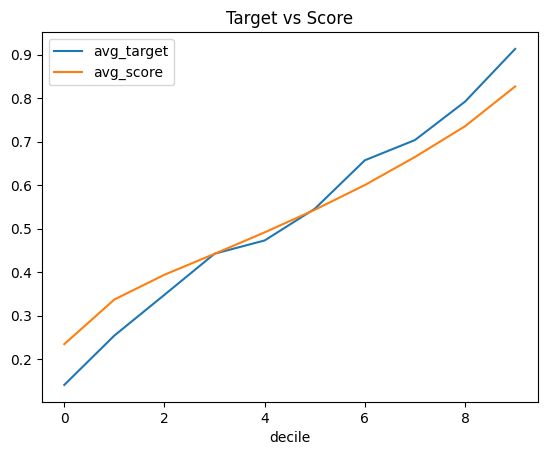

In [117]:
train_summ[["avg_target","avg_score" ]].plot(title="Target vs Score")

OVERALL KPIs Report

In [118]:
train_business_metrics_current = pd.DataFrame({
    "Loans" : [train_summ.n.sum()],
    "LoanAmount" : [train_summ.LoanAmount.sum()],
    "NetMargin" : [train_summ.NetMargin.sum()],
    "NetMargin_pct" : [(train_summ.NetMargin.sum() / train_summ.LoanAmount.sum()).round(4)*100],
    "Margin_per_client" : [(train_summ.NetMargin.sum()/train_summ.n.sum()).round(2)],

},
index=["Current"]
)
train_business_metrics_current

Loans  LoanAmount  NetMargin  NetMargin_pct  Margin_per_client
Current  13129   8092364.0  410346.63           5.07              31.25

OPTIMIZED KPIs Report
1. Optimized DF consists on excluding riskiest Decile
2. This causes a decrease in Loan Origination and is expected to increase %Net Margin

In [119]:
train_summ_cut =  train_summ[train_summ.index != 9]

train_business_metrics_optimized = pd.DataFrame({
    "Loans" : [train_summ_cut.n.sum()],
    "LoanAmount" : [train_summ_cut.LoanAmount.sum()],
    "NetMargin" : [train_summ_cut.NetMargin.sum()],
    "NetMargin_pct" : [(train_summ_cut.NetMargin.sum() / train_summ_cut.LoanAmount.sum()).round(4)*100],
    "Margin_per_client" : [(train_summ_cut.NetMargin.sum()/train_summ_cut.n.sum()).round(2)],
},
index=["Optimized"]
)
train_business_metrics_optimized

Loans  LoanAmount   NetMargin  NetMargin_pct  Margin_per_client
Optimized  11816   7217589.0  1025818.73          14.21              86.82

#### Test DF Report

In [120]:
print("Test Decile Summary")
test_summ = decile_summary(df_test_w_score)
test_summ

Test Decile Summary


n  min_score  max_score  sum_target   sum_score  avg_target  \
decile                                                                  
0.0     421   0.087716   0.297010          95   97.216406    0.225653   
1.0     424   0.297046   0.369424         164  142.714243    0.386792   
2.0     419   0.369633   0.418666         156  165.230299    0.372315   
3.0     435   0.418864   0.466637         193  192.124281    0.443678   
4.0     439   0.466728   0.517187         202  216.544471    0.460137   
5.0     479   0.517533   0.571128         250  259.896361    0.521921   
6.0     417   0.571495   0.630273         235  250.536340    0.563549   
7.0     453   0.630335   0.702083         285  301.162871    0.629139   
8.0     437   0.702307   0.772463         337  321.681056    0.771167   
9.0     452   0.772758   0.934363         389  372.723636    0.860619   

        avg_score  LoanAmount  PaymentAmountPaid  GrossMargin  NetMargin  \
decile                                                                     
0.0      0.230918    243226.0          404794.22    161568.22  149227.22   
1.0      0.336590    251128.0          358039.77    106911.77   98035.77   
2.0      0.394344    252575.0          356363.05    103788.05   96748.05   
3.0      0.441665    283075.0          362475.90     79400.90   72353.90   
4.0      0.493268    273175.0          337317.63     64142.63   59540.63   
5.0      0.542581    316928.0          346229.57     29301.57   25167.57   
6.0      0.600807    255426.0          256486.20      1060.20   -2014.80   
7.0      0.664819    284276.0          240103.34    -44172.66  -47405.66   
8.0      0.736112    285375.0          161733.49   -123641.51 -128043.51   
9.0      0.824610    300275.0          128542.14   -171732.86 -176477.86   

        population_distr  target_distr  no_target_distr      KS      MAPE  \
decile                                                                      
0.0             0.096207      0.041197         0.157488  0.1163  0.023331   
1.0             0.096892      0.071119         0.125604  0.1708  0.129791   
2.0             0.095750      0.067650         0.127053  0.2302  0.059169   
3.0             0.099406      0.083695         0.116908  0.2634  0.004537   
4.0             0.100320      0.087598         0.114493  0.2903  0.072002   
5.0             0.109461      0.108413         0.110628  0.2925  0.039585   
6.0             0.095293      0.101908         0.087923  0.2785  0.066112   
7.0             0.103519      0.123591         0.081159  0.2361  0.056712   
8.0             0.099863      0.146141         0.048309  0.1383  0.045457   
9.0             0.103291      0.168690         0.030435  0.0000  0.041842   

          w_MAPE  
decile            
0.0     0.000961  
1.0     0.009231  
2.0     0.004003  
3.0     0.000380  
4.0     0.006307  
5.0     0.004292  
6.0     0.006737  
7.0     0.007009  
8.0     0.006643  
9.0     0.007058

<Axes: title={'center': 'Target vs Score'}, xlabel='decile'>

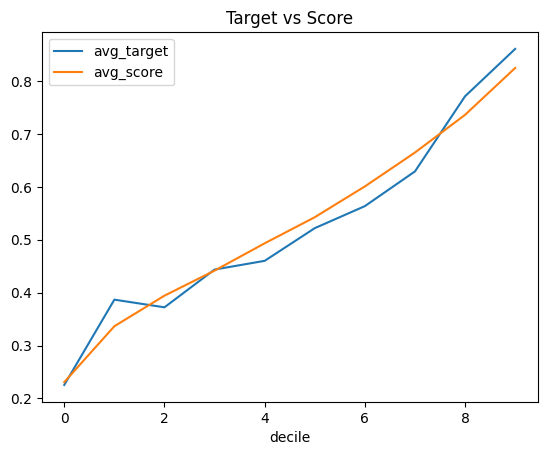

In [121]:
test_summ[["avg_target","avg_score" ]].plot(title="Target vs Score")

OVERALL KPIs Report

In [122]:
test_business_metrics_current = pd.DataFrame({
    "Loans" : [test_summ.n.sum()],
    "LoanAmount" : [test_summ.LoanAmount.sum()],
    "NetMargin" : [test_summ.NetMargin.sum()],
    "NetMargin_pct" : [(test_summ.NetMargin.sum() / test_summ.LoanAmount.sum()).round(4)*100],
    "Margin_per_client" : [(test_summ.NetMargin.sum()/test_summ.n.sum()).round(2)],
},
index=["Current"]
)
test_business_metrics_current

Loans  LoanAmount  NetMargin  NetMargin_pct  Margin_per_client
Current   4376   2745459.0  147131.31           5.36              33.62

OPTIMIZED KPIs Report
1. Optimized DF consists on excluding riskiest Decile
2. This causes a decrease in Loan Origination and is expected to increase %Net Margin

In [123]:
test_summ_cut =  test_summ[test_summ.index != 9]

test_business_metrics_optimized = pd.DataFrame({
    "Loans" : [test_summ_cut.n.sum()],
    "LoanAmount" : [test_summ_cut.LoanAmount.sum()],
    "NetMargin" : [test_summ_cut.NetMargin.sum()],
    "NetMargin_pct" : [(test_summ_cut.NetMargin.sum() / test_summ_cut.LoanAmount.sum()).round(4)*100],
    "Margin_per_client" : [(test_summ_cut.NetMargin.sum()/test_summ_cut.n.sum()).round(2)],
},
index=["Optimized"]
)
test_business_metrics_optimized

Loans  LoanAmount  NetMargin  NetMargin_pct  Margin_per_client
Optimized   3924   2445184.0  323609.17          13.23              82.47

# FINAL REPORT

### Target Definition
Identify customers that will pay less than the Original Loan Amount (NetMargin<0).

### Final model
Final model is s LightGBM with the following parameters 

In [124]:
model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(colsample_bytree=0.8, n_estimators=50, num_leaves=30,
               random_state=127, reg_alpha=0.1, subsample=0.8)>

### Population
This model is planned for:
- New customers (First time loan)
- First time UNIQUE loan.
- Customers with "clearfraudscore" in the third party report

### Feature Importance
This orders the most relevant model variables 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

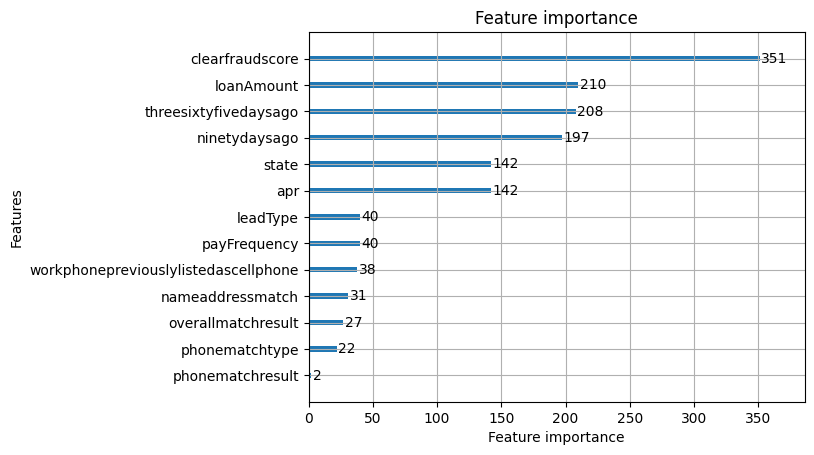

In [125]:
lightgbm.plot_importance(model)

### ML metrics
This shows the metrics from the ML model

In [126]:
#- Test Window Metrics
test_summ

n  min_score  max_score  sum_target   sum_score  avg_target  \
decile                                                                  
0.0     421   0.087716   0.297010          95   97.216406    0.225653   
1.0     424   0.297046   0.369424         164  142.714243    0.386792   
2.0     419   0.369633   0.418666         156  165.230299    0.372315   
3.0     435   0.418864   0.466637         193  192.124281    0.443678   
4.0     439   0.466728   0.517187         202  216.544471    0.460137   
5.0     479   0.517533   0.571128         250  259.896361    0.521921   
6.0     417   0.571495   0.630273         235  250.536340    0.563549   
7.0     453   0.630335   0.702083         285  301.162871    0.629139   
8.0     437   0.702307   0.772463         337  321.681056    0.771167   
9.0     452   0.772758   0.934363         389  372.723636    0.860619   

        avg_score  LoanAmount  PaymentAmountPaid  GrossMargin  NetMargin  \
decile                                                                     
0.0      0.230918    243226.0          404794.22    161568.22  149227.22   
1.0      0.336590    251128.0          358039.77    106911.77   98035.77   
2.0      0.394344    252575.0          356363.05    103788.05   96748.05   
3.0      0.441665    283075.0          362475.90     79400.90   72353.90   
4.0      0.493268    273175.0          337317.63     64142.63   59540.63   
5.0      0.542581    316928.0          346229.57     29301.57   25167.57   
6.0      0.600807    255426.0          256486.20      1060.20   -2014.80   
7.0      0.664819    284276.0          240103.34    -44172.66  -47405.66   
8.0      0.736112    285375.0          161733.49   -123641.51 -128043.51   
9.0      0.824610    300275.0          128542.14   -171732.86 -176477.86   

        population_distr  target_distr  no_target_distr      KS      MAPE  \
decile                                                                      
0.0             0.096207      0.041197         0.157488  0.1163  0.023331   
1.0             0.096892      0.071119         0.125604  0.1708  0.129791   
2.0             0.095750      0.067650         0.127053  0.2302  0.059169   
3.0             0.099406      0.083695         0.116908  0.2634  0.004537   
4.0             0.100320      0.087598         0.114493  0.2903  0.072002   
5.0             0.109461      0.108413         0.110628  0.2925  0.039585   
6.0             0.095293      0.101908         0.087923  0.2785  0.066112   
7.0             0.103519      0.123591         0.081159  0.2361  0.056712   
8.0             0.099863      0.146141         0.048309  0.1383  0.045457   
9.0             0.103291      0.168690         0.030435  0.0000  0.041842   

          w_MAPE  
decile            
0.0     0.000961  
1.0     0.009231  
2.0     0.004003  
3.0     0.000380  
4.0     0.006307  
5.0     0.004292  
6.0     0.006737  
7.0     0.007009  
8.0     0.006643  
9.0     0.007058

In [127]:
decile9_MAPE_train = train_summ[train_summ.index == train_summ.index.max()]["MAPE"].values[0]
decile9_MAPE_test = test_summ[test_summ.index == test_summ.index.max()]["MAPE"].values[0]

train_metrics = pd.DataFrame({
"KS ": [train_summ['KS'].max()],
"Weighted_MAPE ": [train_summ['w_MAPE'].sum()],
"Decile9_MAPE ": [decile9_MAPE_train]
},
index = ["train"]
)

test_metrics = pd.DataFrame({
"KS ": [test_summ['KS'].max()],
"Weighted_MAPE ": [test_summ['w_MAPE'].sum()],
"Decile9_MAPE ": [decile9_MAPE_test]
},
index = ["test"]
)

pd.concat([train_metrics,test_metrics],axis=0)

KS   Weighted_MAPE   Decile9_MAPE 
train  0.3918        0.091542       0.094474
test   0.2925        0.052621       0.041842

In [128]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

# Confusion matrix metrics
def conf_matrix_metrics(y_test, y_pred, score):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)

    # AUC and AUCPR
    roc_auc = roc_auc_score(y_test, score)
    aucpr = average_precision_score(y_test, score)
    
    df= pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "Specificity": [specificity],
        "F1": [f1],
        "AUC": [roc_auc],
        "AUCPR": [aucpr]
    }
    )
    return df

In [129]:
cm_train = conf_matrix_metrics(df_train_w_score[target],
                    df_train_w_score["y_pred"],
                    df_train_w_score["score"])
cm_test= conf_matrix_metrics(df_test_w_score[target],
                    df_test_w_score["y_pred"],
                    df_test_w_score["score"])

cm_train.index=["Train"]
cm_test.index=["Test"]
pd.concat([cm_train,cm_test],axis=0).round(3)*100

Accuracy  Precision  Recall  Specificity    F1   AUC  AUCPR
Train      69.6       70.9    72.0         67.0  71.4  76.9   78.7
Test       64.4       65.6    68.4         60.0  67.0  70.6   73.6

### Business Metrics

This shows the Current Margin vs the Margin we can achive by excluding population from the riskiest decile (decile 9)
- Just by taking away the riskiest 10% of the population, we could improve then %NetMargin ~7.8pp .
- In abosulute values, the margin per client will increase 2.4x

In [130]:
business_kpis = pd.concat([test_business_metrics_current,test_business_metrics_optimized], axis=0).T
business_kpis["diff"] = business_kpis["Optimized"] - business_kpis["Current"] 
business_kpis

Current   Optimized       diff
Loans                 4376.00     3924.00    -452.00
LoanAmount         2745459.00  2445184.00 -300275.00
NetMargin           147131.31   323609.17  176477.86
NetMargin_pct            5.36       13.23       7.87
Margin_per_client       33.62       82.47      48.85